In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import LTransform as LT
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import torch as th
import pandas as pd
import seaborn as sns

In [2]:
# read files 
data_dir = create_directory(directory_name='try11')

model_num = 11
model_name = "model{:02d}".format(model_num)

all_hidden = []
for phase in range(1,5):
    # check if phase is equal to 1 or 3
    ff_coefficient = 0
    if phase == 2 or phase == 4:
        ff_coefficient = 10
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
    cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]
    _, _, all_hidden_, _, _ = test(cfg_file,weight_file,ff_coefficient=ff_coefficient)
    all_hidden.append(np.array(all_hidden_))

Directory '/Users/mahdiyar/Documents/Data/MotorNet/try11' already exists.


In [3]:
# Perform PCA on network hidden units trajectories
X = (all_hidden[0]+all_hidden[2])/2 # cond X time X units
c_mean = np.mean(X,axis=0,keepdims=True) # condition mean
X_n = (X - c_mean)

transform = LT.Transform(num_latent=5)
transform.fit(X_n,method='PCA')

X1_ld = transform.transform(all_hidden[0]-c_mean,ensure_orthogonality=True)
X3_ld = transform.transform(all_hidden[2]-c_mean,ensure_orthogonality=True)

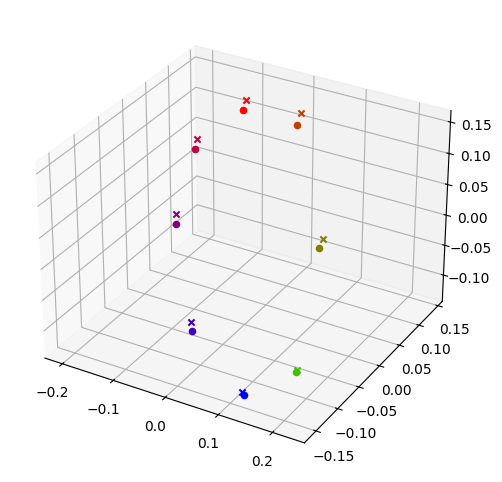

In [5]:
#fig, ax = plot.plot_traj([X1_ld, X3_ld],which_times=list(range(0,25)),plot_scatter=0)
fig, ax = plot.plot_traj([X1_ld, X3_ld],which_times=[24],plot_scatter=1)

In [6]:
X = np.concatenate((all_hidden[0][:,None,:24,:],all_hidden[2][:,None,:24,:]), axis=1)

# make it:
# neurons x conditions x learning phase x time
R = X.transpose(3,0,1,2)
dims = R.shape
# centre data
R -= np.mean(R.reshape((dims[0],-1)),1)[:,None,None,None]

# fit
dpca = dPCA.dPCA(labels='clt',join={'ct':['c','ct'], 'lt':['l','lt'], 'clt':['cl','clt']}, n_components=6)
dpca.protect = ['t']
Z = dpca.fit_transform(R)
#dpca.fit(R)

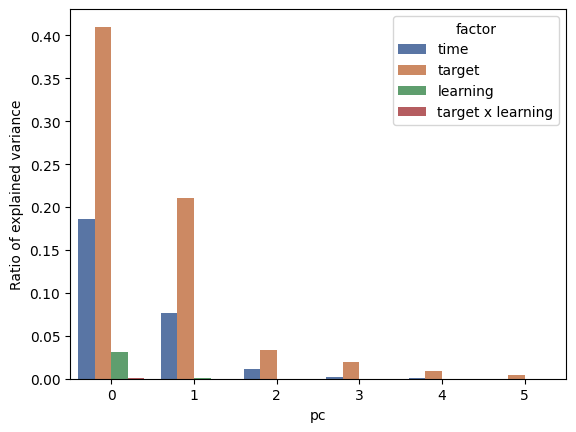

In [8]:
var_explained_df = pd.DataFrame(columns=['factor', 'pc', 'variance_explained'])
counter = 0
good_names=['time','target','learning','target x learning']
for i,name in enumerate(dpca.explained_variance_ratio_.keys()):
    for c in range(dpca.n_components):
        var_explained_df.loc[counter] = {'factor': good_names[i], 'pc': c, 'variance_explained': dpca.explained_variance_ratio_[name][c]}
        counter += 1

fig,ax = plt.subplots()
sns.barplot(var_explained_df, x='pc', y='variance_explained', hue='factor', palette=sns.color_palette('deep',4))
ax.set_ylabel('Ratio of explained variance')
fig.savefig(os.path.join(data_dir,'varexplained.png'),dpi=300)

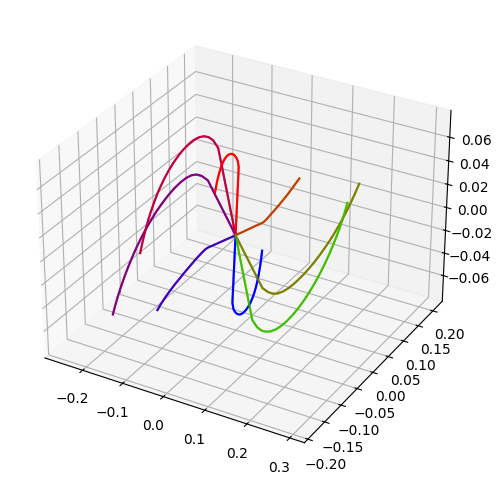

In [13]:
x_1 = Z['ct'][:,:,0,:].transpose(1,2,0)
x_2 = Z['ct'][:,:,1,:].transpose(1,2,0)
fig, ax = plot.plot_traj([x_1, x_2],which_times=list(range(0,24)),plot_scatter=0)
#fig.savefig(os.path.join(data_dir,'dpca_condition.png'),dpi=300)